---
# Import libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

---
# Load GPU

In [ ]:
!nvidia-smi

Mon May 16 05:31:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

---
# Load CIFAR10

In [ ]:
(x_trainval, y_trainval), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(type(x_trainval), x_trainval.shape)
print(type(y_trainval), y_trainval.shape)

x_train, x_valid, y_train, y_valid = train_test_split(x_trainval, y_trainval, test_size= 1/6, shuffle=True, stratify = y_trainval, random_state=34)
print(type(x_train), x_train.shape)
print(type(y_train), y_train.shape)

170508288/170498071 [==============================] - 11s 0us/step
<class 'numpy.ndarray'> (50000, 32, 32, 3)
<class 'numpy.ndarray'> (50000, 1)
<class 'numpy.ndarray'> (41666, 32, 32, 3)
<class 'numpy.ndarray'> (41666, 1)


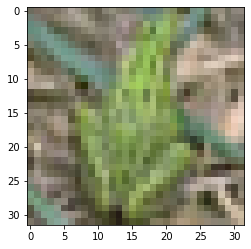

In [ ]:
plt.imshow(x_train[0])

In [ ]:
# Scale to [0, 1]
x_train, x_valid, x_test = x_train.astype('float32') / 255 , x_valid.astype('float32') / 255, x_test.astype('float32') / 255 

In [ ]:
print(x_train[0].shape)
num_features = np.prod(x_train[0].shape)
print(num_features) 

(32, 32, 3)
3072


In [ ]:
x_train = x_train.reshape(-1, num_features)
x_valid = x_valid.reshape(-1, num_features)
x_test = x_test.reshape(-1, num_features)
print(x_train.shape, x_valid.shape, x_test.shape)

(41666, 3072) (8334, 3072) (10000, 3072)


---
# Train

In [ ]:
def train(net, x_train, y_train, x_valid, y_valid, x_test, y_test):
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    net.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

    result = net.fit(x_train, y_train, epochs = 15, batch_size = 128, validation_data = (x_valid, y_valid), verbose = 0)

    print('Test accuracy')

    test_result = net.evaluate(x_test, y_test)

    plt.plot(result.history['accuracy'])
    plt.plot(result.history['val_accuracy'])
    plt.title('ACCURACY')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend(['train','validation'], loc = 'best')

In [ ]:
data = [x_train, y_train, x_valid, y_valid, x_test, y_test]

---
# Sigmoid VS ReLU

In [ ]:
class ActivationNet(Model):
    # Set layers.
    def __init__(self, activation, num_classes=10):
        super(ActivationNet, self).__init__()
        self.fc1 = layers.Dense(64, activation=activation)
        self.fc2 = layers.Dense(128, activation=activation)
        self.out = layers.Dense(num_classes)

    # Set forward pass.
    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        x = tf.nn.softmax(x)
        return x

## Sigmoid

Test accuracy
313/313 [==============================] - 1s 3ms/step - loss: 2.0105 - accuracy: 0.2808


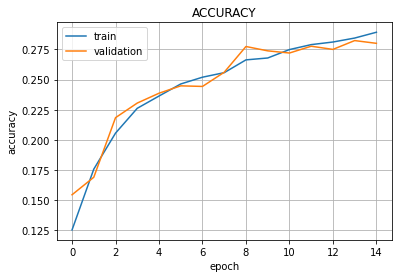

In [ ]:
net = ActivationNet('sigmoid')
train(net, *data)

## ReLU

Test accuracy
313/313 [==============================] - 1s 3ms/step - loss: 1.5959 - accuracy: 0.4304


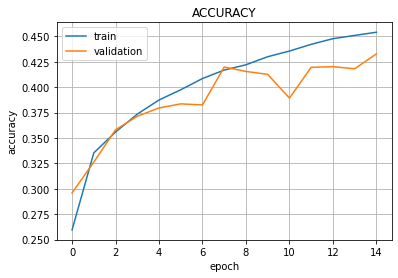

In [ ]:
net = ActivationNet('relu')
train(net, *data)

---
# Initialization 
## Normal vs Xavier

In [ ]:
fc = layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal) # Xavier
print(fc.kernel_initializer)

In [ ]:
fc = layers.Dense(128, activation='relu', kernel_initializer='glorot_normal')
print(fc.kernel_initializer)

In [ ]:
class InitializationNet(Model):
    # Set layers.
    def __init__(self, initializer, num_classes=10):
        super(InitializationNet, self).__init__()
        self.fc1 = layers.Dense(128, activation='relu', kernel_initializer=initializer)
        self.fc2 = layers.Dense(128, activation='relu', kernel_initializer=initializer)
        self.out = layers.Dense(num_classes, kernel_initializer=initializer)

    # Set forward pass.
    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        x = tf.nn.softmax(x)
        return x

In [ ]:
class InitializationNet(Model):
    # Set layers.
    def __init__(self, initializer, num_classes=10):
        super(InitializationNet, self).__init__()
        self.fc1 = layers.Dense(128, activation='sigmoid', kernel_initializer=initializer)
        self.fc2 = layers.Dense(256, activation='sigmoid', kernel_initializer=initializer)
        self.out = layers.Dense(num_classes, kernel_initializer=initializer)

    # Set forward pass.
    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        x = tf.nn.softmax(x)
        return x

---
# Normal

Test accuracy
313/313 [==============================] - 1s 3ms/step - loss: 2.0813 - accuracy: 0.2382


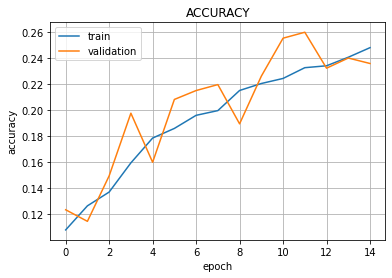

In [ ]:
net = InitializationNet('normal')
train(net, *data)

---
# Xavier

Test accuracy
313/313 [==============================] - 1s 3ms/step - loss: 1.9781 - accuracy: 0.3010


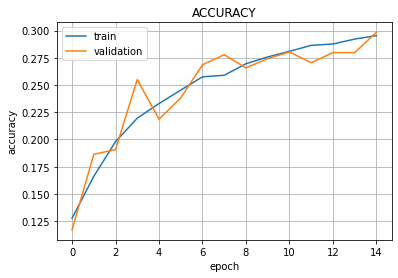

In [ ]:
net = InitializationNet('glorot_normal')
train(net, *data)

---
# Batch Normalization

In [ ]:
class BNNet(Model):
    # Set layers.
    def __init__(self, num_classes=10):
        super(BNNet, self).__init__()
        self.fc1 = layers.Dense(64, activation='relu')
        self.fc2 = layers.Dense(128, activation='relu')
        self.out = layers.Dense(num_classes)

    # Set forward pass.
    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        x = tf.nn.softmax(x)
        return x

Test accuracy
313/313 [==============================] - 1s 3ms/step - loss: 1.5850 - accuracy: 0.4379


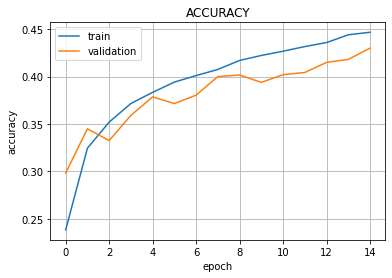

In [ ]:
net = BNNet()
train(net, *data)

In [ ]:
class BNNet(Model):
    # Set layers.
    def __init__(self, num_classes=10):
        super(BNNet, self).__init__()
        self.fc1 = layers.Dense(64, activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.fc2 = layers.Dense(128, activation='relu')
        self.bn2 = layers.BatchNormalization()
        self.out = layers.Dense(num_classes)

    # Set forward pass.
    def call(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.out(x)
        x = tf.nn.softmax(x)
        return x

Test accuracy
313/313 [==============================] - 1s 3ms/step - loss: 1.5274 - accuracy: 0.4619


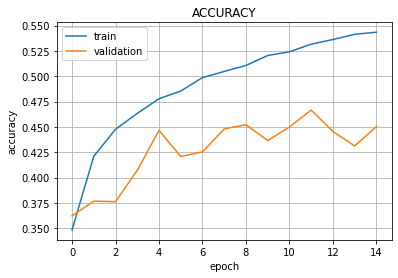

In [ ]:
net = BNNet()
train(net, *data)

---
# Optimizers

In [ ]:
class OptimizerNet(Model):
    # Set layers.
    def __init__(self, num_classes=10):
        super(OptimizerNet, self).__init__()
        self.fc1 = layers.Dense(64, activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.fc2 = layers.Dense(128, activation='relu')
        self.bn2 = layers.BatchNormalization()
        self.out = layers.Dense(num_classes)

    # Set forward pass.
    def call(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.out(x)
        x = tf.nn.softmax(x)
        return x

In [ ]:
def train_SGD(net, x_train, y_train, x_valid, y_valid, x_test, y_test):
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    net.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

    result = net.fit(x_train, y_train, epochs = 15, batch_size = 128, validation_data = (x_valid, y_valid), verbose = 0)

    print('Test accuracy')

    test_result = net.evaluate(x_test, y_test)

    plt.plot(result.history['accuracy'])
    plt.plot(result.history['val_accuracy'])
    plt.title('ACCURACY')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend(['train','validation'], loc = 'best')

In [ ]:
def train_SGD_Momentum(net, x_train, y_train, x_valid, y_valid, x_test, y_test):
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    net.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

    result = net.fit(x_train, y_train, epochs = 15, batch_size = 128, validation_data = (x_valid, y_valid), verbose = 0)

    print('Test accuracy')

    test_result = net.evaluate(x_test, y_test)

    plt.plot(result.history['accuracy'])
    plt.plot(result.history['val_accuracy'])
    plt.title('ACCURACY')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend(['train','validation'], loc = 'best')

In [ ]:
def train_Adam(net, x_train, y_train, x_valid, y_valid, x_test, y_test):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    net.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

    result = net.fit(x_train, y_train, epochs = 15, batch_size = 128, validation_data = (x_valid, y_valid), verbose = 0)

    print('Test accuracy')

    test_result = net.evaluate(x_test, y_test)

    plt.plot(result.history['accuracy'])
    plt.plot(result.history['val_accuracy'])
    plt.title('ACCURACY')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend(['train','validation'], loc = 'best')

Test accuracy
313/313 [==============================] - 1s 3ms/step - loss: 1.5150 - accuracy: 0.4689


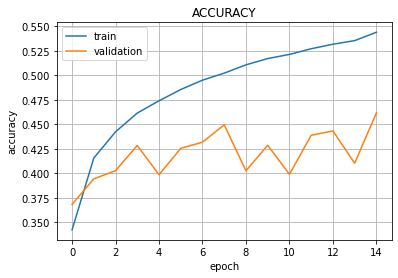

In [ ]:
net = OptimizerNet()
train_SGD(net, *data)

Test accuracy
313/313 [==============================] - 1s 3ms/step - loss: 1.5730 - accuracy: 0.4722


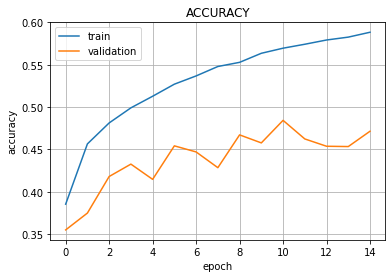

In [ ]:
net = OptimizerNet()
train_SGD_Momentum(net, *data)

Test accuracy
313/313 [==============================] - 1s 3ms/step - loss: 1.4995 - accuracy: 0.4794


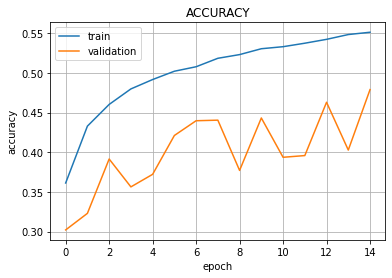

In [ ]:
net = OptimizerNet()
train_Adam(net, *data)